### 1. Import needed packages and clone the dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
!pip install split-folders
import splitfolders
from sklearn.datasets import load_files
from keras.utils import np_utils, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense ,Conv2D , MaxPooling2D , Flatten , Activation , Dropout ,Lambda
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

print('You are using numpy version:', np.__version__)

#Clone dataset from Github
#!git clone https://github.com/Horea94/Fruit-Images-Dataset

#Set the path to the dataset
train_dir = 'C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Training/'
test_dir = 'C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Test/'

#splitfolders.ratio(train_dir, output='C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/NewSplit/', seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False)

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files, targets, target_labels

#for descriptive statisitcs: load training, validation and test set (names, intclass and stringclass of images)
newSplit_dir = 'C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/NewSplit/'
names_train, intclass_train, stringclass_train = load_dataset(newSplit_dir+'train')
names_val, intclass_val, stringclass_val = load_dataset(newSplit_dir+'val')
names_test, intclass_test, stringclass_test = load_dataset(newSplit_dir+'test')
names_orig_test, intclass_orig_test, stringclass_orig_test = load_dataset(test_dir)

#count how many unqiue classes we have in the dataset
n_classes = len(np.unique(intclass_test))

#convert integer class to one-hot encoded categorical class
#train_hot_class = np_utils.to_categorical(intclass_train, n_classes)
#test_hot_class = np_utils.to_categorical(intclass_test, n_classes)

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

#load each image and convert to array of images
train_images_array = np.array(convert_image_to_array(names_train))
val_images_array = np.array(convert_image_to_array(names_val))
test_images_array = np.array(convert_image_to_array(names_test))
orig_test_images_array = np.array(convert_image_to_array(names_orig_test))

#standardization of pixel values to a 0;1 range
train_images_array = train_images_array.astype('float32')/255
val_images_array = val_images_array.astype('float32')/255
test_images_array = test_images_array.astype('float32')/255
orig_test_images_array = orig_test_images_array.astype('float32')/255

You are using numpy version: 1.20.1


#### First look at the dataset properties

In [3]:
print('Training set: ', train_images_array.shape)
print('Validation set: ', val_images_array.shape)
print('Test set: ', test_images_array.shape)
print('original Test set: ',orig_test_images_array.shape)
print(stringclass_train)

Training set:  (40585, 100, 100, 3)
Validation set:  (13502, 100, 100, 3)
Test set:  (13605, 100, 100, 3)
original Test set:  (22688, 100, 100, 3)
['Apple Braeburn' 'Apple Crimson Snow' 'Apple Golden 1' 'Apple Golden 2'
 'Apple Golden 3' 'Apple Granny Smith' 'Apple Pink Lady' 'Apple Red 1'
 'Apple Red 2' 'Apple Red 3' 'Apple Red Delicious' 'Apple Red Yellow 1'
 'Apple Red Yellow 2' 'Apricot' 'Avocado' 'Avocado ripe' 'Banana'
 'Banana Lady Finger' 'Banana Red' 'Beetroot' 'Blueberry' 'Cactus fruit'
 'Cantaloupe 1' 'Cantaloupe 2' 'Carambula' 'Cauliflower' 'Cherry 1'
 'Cherry 2' 'Cherry Rainier' 'Cherry Wax Black' 'Cherry Wax Red'
 'Cherry Wax Yellow' 'Chestnut' 'Clementine' 'Cocos' 'Corn' 'Corn Husk'
 'Cucumber Ripe' 'Cucumber Ripe 2' 'Dates' 'Eggplant' 'Fig' 'Ginger Root'
 'Granadilla' 'Grape Blue' 'Grape Pink' 'Grape White' 'Grape White 2'
 'Grape White 3' 'Grape White 4' 'Grapefruit Pink' 'Grapefruit White'
 'Guava' 'Hazelnut' 'Huckleberry' 'Kaki' 'Kiwi' 'Kohlrabi' 'Kumquats'
 'Lemon' 

## 2. Exploratory Data Analysis

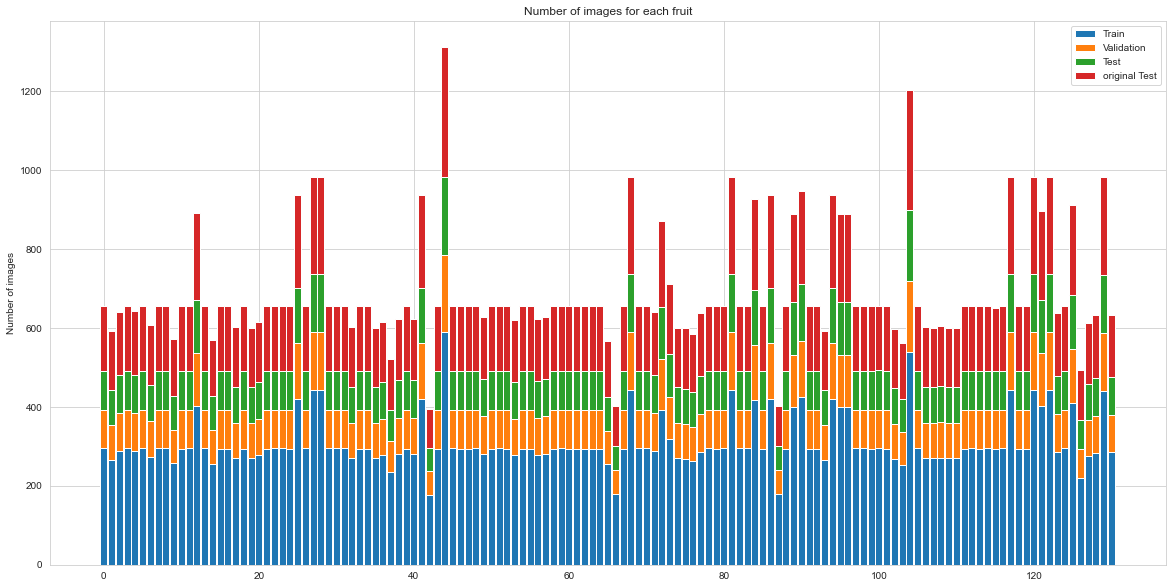

In [4]:
#Plot the distribution of images
(class_number_train, class_count_train) = np.unique(intclass_train, return_counts=True)
(class_number_val, class_count_val) = np.unique(intclass_val, return_counts=True)
(class_number_test, class_count_test) = np.unique(intclass_test, return_counts=True)
(class_number_orig_test, class_count_orig_test) = np.unique(intclass_orig_test, return_counts=True)
labels = class_number_train
width = 0.9
fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(labels, class_count_train, width, label='Train')
ax.bar(labels, class_count_val, width, bottom=class_count_train, label='Validation')
ax.bar(labels, class_count_test, width, bottom=class_count_train+class_count_val, label='Test')
ax.bar(labels, class_count_orig_test, width, bottom=class_count_train+class_count_val+class_count_test, label='original Test')
ax.set_ylabel('Number of images')
ax.set_title('Number of images for each fruit')
ax.legend()

plt.show()

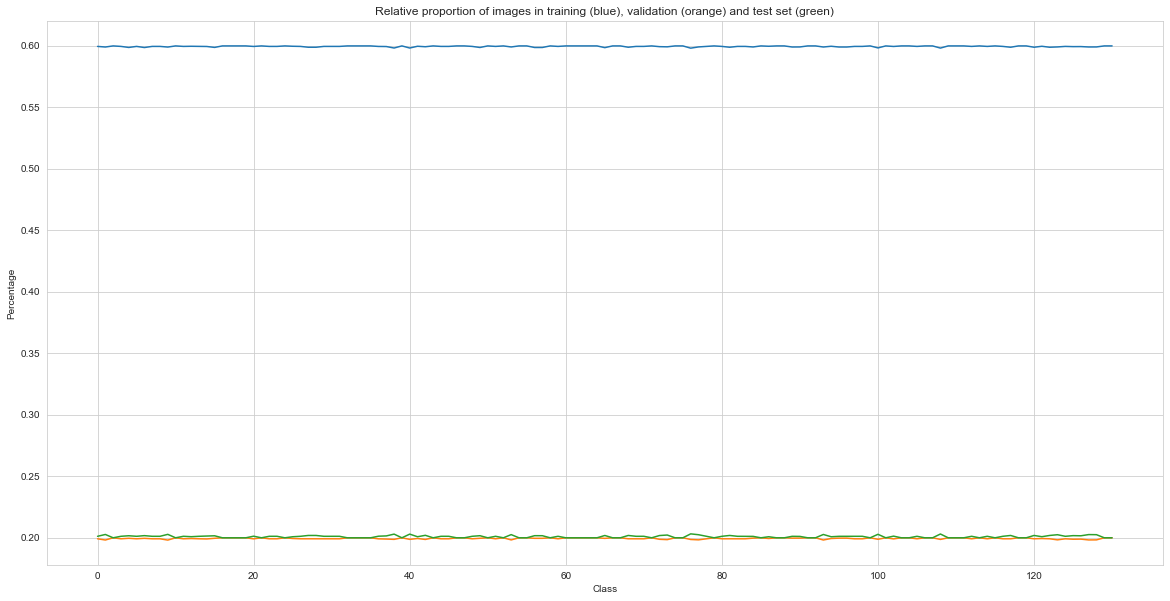

In [5]:
# Visualize relative proportion of images in the train/validation/test compared to the whole dataset
all_images = class_count_train+class_count_val+class_count_test
proportion_train = class_count_train / all_images
proportion_val = class_count_val / all_images
proportion_test = class_count_test / all_images

plt.figure(figsize=(20, 10))
plt.plot(proportion_train, label='Train')
plt.plot(proportion_val, label='Validation')
plt.plot(proportion_test, label='Test')
plt.title('Relative proportion of images in training (blue), validation (orange) and test set (green)')
plt.xlabel("Class")
plt.ylabel("Percentage")
#plt.ylim([0.19,0.21])
plt.show()

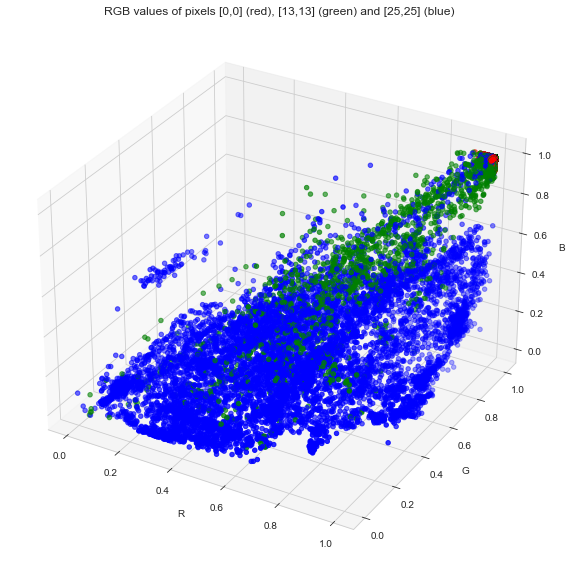

In [6]:
#Plot the RGB values of specific pixels

#how many observations for scatterplot
n_images = 10000
#what pixels for scatterplot
pixel1 = 0
pixel2 = 13
pixel3 = 25
arr1 = []
arr2 = []
arr3 = []

for i in range(n_images):
    arr1.append(train_images_array[i][pixel1][pixel1])
    arr2.append(train_images_array[i][pixel2][pixel2])
    arr3.append(train_images_array[i][pixel3][pixel3])

df1 = pd.DataFrame(arr1)
df1['pixel'] = pixel1
df2 = pd.DataFrame(arr2)
df2['pixel'] = pixel2
df3 = pd.DataFrame(arr3)
df3['pixel'] = pixel3

rgb_data = df1.append(df2.append(df3))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
colors = {pixel1:'red', pixel2:'green', pixel3:'blue'}
ax.scatter(rgb_data[0], rgb_data[1], rgb_data[2], c=rgb_data['pixel'].map(colors))
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
plt.title('RGB values of pixels [0,0] (red), [13,13] (green) and [25,25] (blue)')
plt.show()

C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/NewSplit/train\Tomato 4\7_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/NewSplit/train\Plum 3\r3_123_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/NewSplit/train\Grape Blue\24_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/NewSplit/train\Kaki\207_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/NewSplit/train\Pear Williams\r_38_100.jpg
C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Found

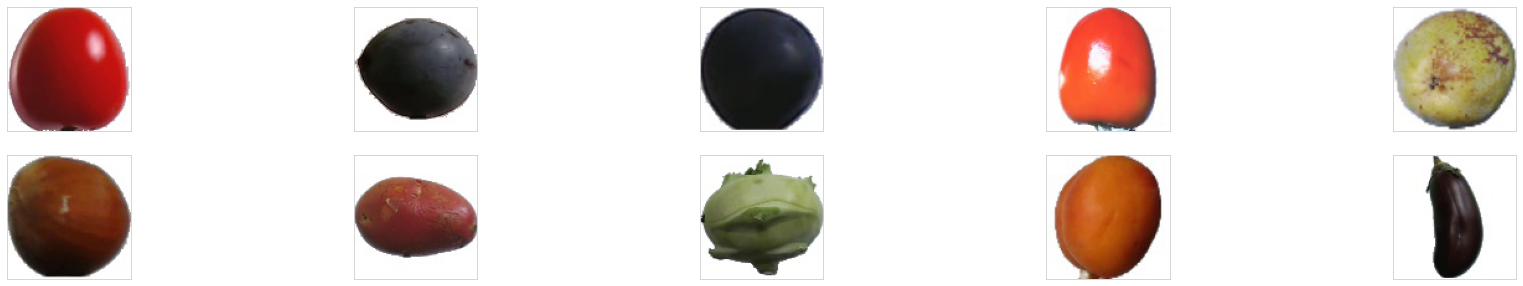

In [7]:
#plot 10 images of fruits
fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(train_images_array[i]))
    print(names_train[i])
plt.show()

## 3. Replication of CNN from original paper

In [8]:
#Data preparation
image_size = (100 , 100) # width and height of the used images

def augment_image(x):
    x = tf.image.random_saturation (x, 0.9 , 1.2)
    x = tf.image.random_hue (x, 0.02)
    return x

test_dir = os.path.join(newSplit_dir ,'test')
train_dir = os.path.join(newSplit_dir , 'train')
val_dir = os.path.join(newSplit_dir , 'val')
output_dir = 'output_files'

if not os.path.exists(output_dir):
    os. makedirs (output_dir)# if we want to train the network for a subset of the fruit classes instead of all , we can set theuse_label_file to true and place in the label_filethe classes we want to train for , one per line

use_label_file = False

if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir ( train_dir )

num_classes = len( labels )

train_datagen = ImageDataGenerator(width_shift_range =0.0 , height_shift_range =0.0 ,zoom_range =0.0 , horizontal_flip =True ,vertical_flip =True , preprocessing_function =augment_image) # augmentation is done only onthe train set (and optionally validation )
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
origtest_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(train_dir , target_size = image_size ,class_mode ='sparse', batch_size = 50,shuffle =True , subset =None, classes = labels)
val_gen = val_datagen.flow_from_directory(val_dir , target_size = image_size ,class_mode ='sparse', batch_size = 50,shuffle =True , subset =None, classes = labels)
test_gen = test_datagen.flow_from_directory(test_dir , target_size = image_size , class_mode='sparse', batch_size = 50 , shuffle =False, subset =None , classes = labels)
origtest_gen = origtest_datagen.flow_from_directory('C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/Pycharm/Fruit-Images-Dataset/Test/' , target_size = image_size , class_mode='sparse', batch_size = 50 , shuffle =False, subset =None , classes = labels)

Found 40585 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 13605 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [9]:
#Model preparation

learning_rate = 0.1 # initial learning rate
min_learning_rate = 0.00001 # once the learning rate reaches this value , do not decrease it further
learning_rate_reduction_factor = 0.5 # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 3 # how many epochs to wait beforereducing the learning rate when the loss plateaus
verbose = 1 # controls the amount of logging doneduring training and testing : 0 - none , 1 - reportsmetrics after each batch , 2 - reports metrics after each epoch
input_shape = (100 , 100 , 3)
num_classes = 131
img_input = Input( shape = input_shape , name='data')

x = Conv2D(16 , (5, 5) , strides =(1 , 1) , padding ='same', name='conv1')(img_input)
x = Activation('relu', name='conv1_relu')(x)
x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool1')(x)
x = Conv2D(32 , (5, 5) , strides =(1 , 1) , padding ='same', name='conv2')(x)
x = Activation('relu', name='conv2_relu')(x)
x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool2')(x)
x = Conv2D(64 , (5, 5) , strides =(1 , 1) , padding ='same', name='conv3')(x)
x = Activation('relu', name='conv3_relu')(x)
x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool3')(x)
x = Conv2D(128 , (5, 5) , strides =(1 , 1) , padding ='same', name='conv4')(x)
x = Activation('relu', name='conv4_relu')(x)
x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool4')(x)
x = Flatten()(x)
x = Dense(1024 , activation ='relu', name='fcl1')(x)
x = Dropout(0.2) (x)
x = Dense(256 , activation ='relu', name='fcl2')(x)
x = Dropout(0.2)(x)
out = Dense(num_classes , activation ='softmax', name='predictions')(x)
origModel = Model(inputs =img_input , outputs =out)
origModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data (InputLayer)           [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 100, 100, 16)      1216      
                                                                 
 conv1_relu (Activation)     (None, 100, 100, 16)      0         
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 50, 50, 32)        12832     
                                                                 
 conv2_relu (Activation)     (None, 50, 50, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 25, 32)        0     

In [10]:
# Training of Model

optimizer = Adadelta(lr=learning_rate)
origModel.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
learning_rate_reduction= ReduceLROnPlateau(monitor ='loss', patience =patience , verbose =verbose ,factor=learning_rate_reduction_factor,min_lr=min_learning_rate)
modelname = 'origModel'
save_model = ModelCheckpoint(filepath = modelname+'.hdf5', verbose = verbose, save_best_only = True, monitor ='loss' ,save_weights_only = False , mode='min',save_freq ='epoch')
history = origModel.fit(train_gen,validation_data=val_gen, epochs =25,steps_per_epoch =( train_gen.n // 50) + 1,verbose =verbose , callbacks =[learning_rate_reduction , save_model])
np.save(modelname+'_history.npy',history.history)

C:\Users\crysi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


Epoch 1/25
812/812 [==============================] - ETA: 0s - loss: 3.6091 - acc: 0.2407
Epoch 1: loss improved from inf to 3.60912, saving model to origModel.hdf5
812/812 [==============================] - 267s 328ms/step - loss: 3.6091 - acc: 0.2407 - val_loss: 0.8362 - val_acc: 0.7851 - lr: 0.1000
Epoch 2/25
812/812 [==============================] - ETA: 0s - loss: 0.8009 - acc: 0.7665
Epoch 2: loss improved from 3.60912 to 0.80091, saving model to origModel.hdf5
812/812 [==============================] - 245s 302ms/step - loss: 0.8009 - acc: 0.7665 - val_loss: 0.1909 - val_acc: 0.9429 - lr: 0.1000
Epoch 3/25
812/812 [==============================] - ETA: 0s - loss: 0.3436 - acc: 0.8922
Epoch 3: loss improved from 0.80091 to 0.34359, saving model to origModel.hdf5
812/812 [==============================] - 237s 292ms/step - loss: 0.3436 - acc: 0.8922 - val_loss: 0.0533 - val_acc: 0.9853 - lr: 0.1000
Epoch 4/25
812/812 [==============================] - ETA: 0s - loss: 0.1991 - a

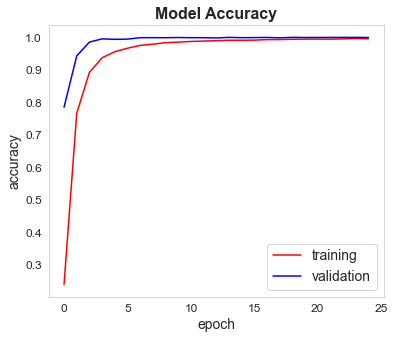

In [23]:
plt.figure(figsize = (6, 5))
plt.plot(history.history['acc'], color = 'r')
plt.plot(history.history['val_acc'], color = 'b')
plt.title('Model Accuracy', weight = 'bold', fontsize = 16)
plt.ylabel('accuracy', fontsize = 14)
plt.xlabel('epoch', fontsize = 14)
#plt.ylim(0.6, 1.05)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(['training', 'validation'], loc = 'lower right', prop = {'size': 14})
plt.grid(color = 'y', linewidth = '0.5')
plt.show()

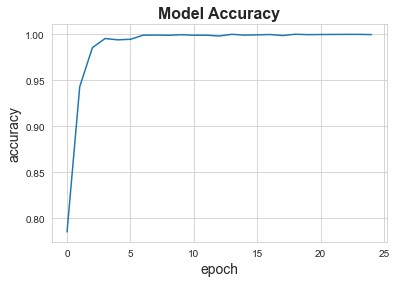

In [25]:
history2=np.load(modelname+'_history.npy',allow_pickle='TRUE').item()
plt.plot(history2['val_acc'])
plt.title('Model Accuracy', weight = 'bold', fontsize = 16)
plt.ylabel('accuracy', fontsize = 14)
plt.xlabel('epoch', fontsize = 14)

plt.show()

In [26]:
# Testing of the Model

origModel.load_weights('C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/ImageClassification/origModel.hdf5')
train_gen.reset()

loss_t , accuracy_t = origModel.evaluate(train_gen ,steps =( train_gen.n // 50) + 1, verbose =verbose)
loss_v , accuracy_v = origModel.evaluate(val_gen ,steps =( val_gen.n // 50) + 1, verbose =verbose)
loss , accuracy = origModel.evaluate(test_gen , steps =(test_gen.n // 50 ) + 1, verbose = verbose )
loss_ot , accuracy_ot = origModel.evaluate(origtest_gen , steps =(origtest_gen.n // 50 ) + 1, verbose = verbose )

print(" Train : accuracy = %f ; loss_v = %f" % (accuracy_t , loss_t ))
print(" Validation : accuracy = %f ; loss_v = %f" % (accuracy_v , loss_v ))
print(" Test : accuracy = %f ; loss_v = %f" % (accuracy , loss ))
print(" original Test: accuracy = %f ; loss_v = %f" % (accuracy_ot , loss_ot))

454/454 [==============================] - 47s 103ms/step - loss: 0.1775 - acc: 0.9709
 Train : accuracy = 0.999556 ; loss_v = 0.001923
 Validation : accuracy = 0.999778 ; loss_v = 0.000608
 Test : accuracy = 0.999706 ; loss_v = 0.001190
 original Test: accuracy = 0.970866 ; loss_v = 0.177509


## 4. Implementation of VGG-16

In [27]:
#Model preparation

learning_rate = 0.1 # initial learning rate
min_learning_rate = 0.00001 # once the learning rate reaches this value , do not decrease it further
learning_rate_reduction_factor = 0.5 # the factor used when reducing the learning rate -> learning_rate *= learning_rate_reduction_factor
patience = 3 # how many epochs to wait beforereducing the learning rate when the loss plateaus
verbose = 1 # controls the amount of logging doneduring training and testing : 0 - none , 1 - reportsmetrics after each batch , 2 - reports metrics after each epoch
image_size = (100 , 100) # width and height of the used images
input_shape = (100 , 100 , 3)
num_classes = 131
img_input = Input( shape = input_shape , name='data')

x = Conv2D(64 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv1-1')(img_input)
x = Activation('relu', name='conv1_relu')(x)

x = Conv2D(64 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv1-2')(img_input)
x = Activation('relu', name='conv1_relu')(x)

x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool1')(x)

x = Conv2D(128 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv2-1')(x)
x = Activation('relu', name='conv2-1_relu')(x)

x = Conv2D(128 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv2-2')(x)
x = Activation('relu', name='conv2-2_relu')(x)

x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool2')(x)

x = Conv2D(256 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv3-1')(x)
x = Activation('relu', name='conv3-1_relu')(x)

x = Conv2D(256 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv3-2')(x)
x = Activation('relu', name='conv3-2_relu')(x)

x = Conv2D(256 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv3-3')(x)
x = Activation('relu', name='conv3-3_relu')(x)

x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool3')(x)

x = Conv2D(512 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv4-1')(x)
x = Activation('relu', name='conv4-1_relu')(x)

x = Conv2D(512 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv4-2')(x)
x = Activation('relu', name='conv4-2_relu')(x)

x = Conv2D(512 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv4-3')(x)
x = Activation('relu', name='conv4-3_relu')(x)

x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool4')(x)

x = Conv2D(512 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv5-1')(x)
x = Activation('relu', name='conv5-1_relu')(x)

x = Conv2D(512 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv5-2')(x)
x = Activation('relu', name='conv5-2_relu')(x)

x = Conv2D(512 , (3, 3) , strides =(1 , 1) , padding ='same', name='conv5-3')(x)
x = Activation('relu', name='conv5-3_relu')(x)

x = MaxPooling2D((2 , 2) , strides =(2 , 2) , padding ='valid', name='pool5')(x)

x = Flatten()(x)

x = Dense(256 , activation ='relu', name='fcl1')(x)
#x = Dropout(0.2) (x)
x = Dense(128 , activation ='relu', name='fcl2')(x)
#x = Dropout(0.2)(x)
out = Dense(num_classes , activation ='softmax', name='predictions')(x)

vgg16 = Model(inputs =img_input , outputs =out)
vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data (InputLayer)           [(None, 100, 100, 3)]     0         
                                                                 
 conv1-2 (Conv2D)            (None, 100, 100, 64)      1792      
                                                                 
 conv1_relu (Activation)     (None, 100, 100, 64)      0         
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 50, 64)        0         
                                                                 
 conv2-1 (Conv2D)            (None, 50, 50, 128)       73856     
                                                                 
 conv2-1_relu (Activation)   (None, 50, 50, 128)       0         
                                                                 
 conv2-2 (Conv2D)            (None, 50, 50, 128)       1475

In [9]:
# Training of Model

optimizer = Adadelta(lr=learning_rate)
vgg16.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
learning_rate_reduction= ReduceLROnPlateau(monitor ='loss', patience =patience , verbose =verbose ,factor=learning_rate_reduction_factor,min_lr=min_learning_rate)
modelname = 'VGG16'
save_model = ModelCheckpoint(filepath = modelname+'.hdf5', verbose = verbose, save_best_only = True, monitor ='loss' ,save_weights_only = False , mode='min',save_freq ='epoch')
history = vgg16.fit(train_gen,validation_data=val_gen, epochs =25,steps_per_epoch =( train_gen.n // 50) + 1,verbose =verbose , callbacks =[learning_rate_reduction , save_model])
np.save(modelname+'_history.npy',history.history)

C:\Users\crysi\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adadelta.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)


Epoch 1/25
812/812 [==============================] - ETA: 0s - loss: 0.0163 - acc: 0.9954
Epoch 1: loss improved from inf to 0.01625, saving model to VGG16.hdf5
812/812 [==============================] - 3584s 4s/step - loss: 0.0163 - acc: 0.9954 - val_loss: 0.0015 - val_acc: 0.9999 - lr: 0.1000
Epoch 2/25
812/812 [==============================] - ETA: 0s - loss: 0.0139 - acc: 0.9962
Epoch 2: loss improved from 0.01625 to 0.01393, saving model to VGG16.hdf5
812/812 [==============================] - 3809s 5s/step - loss: 0.0139 - acc: 0.9962 - val_loss: 0.0051 - val_acc: 0.9990 - lr: 0.1000
Epoch 3/25
812/812 [==============================] - ETA: 0s - loss: 0.0148 - acc: 0.9956
Epoch 3: loss did not improve from 0.01393
812/812 [==============================] - 3794s 5s/step - loss: 0.0148 - acc: 0.9956 - val_loss: 0.0096 - val_acc: 0.9976 - lr: 0.1000
Epoch 4/25
812/812 [==============================] - ETA: 0s - loss: 0.0162 - acc: 0.9955
Epoch 4: loss did not improve from 0.01

KeyboardInterrupt: 

In [31]:
optimizer = Adadelta(lr=learning_rate)
vgg16.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
vgg16.load_weights('C:/Users/crysi/Private Dokumente/Papers & wissenschaftl. Arbeiten/Master/Foundations of Machine Learning/First Project/ImageClassification/VGG16.hdf5')
train_gen.reset()
loss_t , accuracy_t = vgg16.evaluate(train_gen ,steps =( train_gen.n // 50) + 1, verbose =verbose)
loss_v , accuracy_v = vgg16.evaluate(val_gen ,steps =( val_gen.n // 50) + 1, verbose =verbose)
loss , accuracy = vgg16.evaluate(test_gen , steps =(test_gen.n // 50 ) + 1, verbose = verbose )
loss_ot , accuracy_ot = vgg16.evaluate(origtest_gen , steps =(origtest_gen.n // 50 ) + 1, verbose = verbose )
print(" Train : accuracy = %f ; loss_v = %f" % (accuracy_t , loss_t ))
print(" Val : accuracy = %f ; loss_v = %f" % (accuracy_v , loss_v ))
print(" Test: accuracy = %f ; loss_v = %f" % (accuracy , loss))
print(" original Test : accuracy = %f ; loss_v = %f" % (accuracy_ot , loss_ot ))

 Train : accuracy = 0.999754 ; loss_v = 0.000729
 Val : accuracy = 0.999852 ; loss_v = 0.001012
 Test: accuracy = 0.999853 ; loss_v = 0.001265
 original Test : accuracy = 0.964607 ; loss_v = 0.290996
